In [37]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
from numba import vectorize
from collections import defaultdict, Counter
from itertools import product,combinations,chain
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
from scipy.stats import rankdata,percentileofscore
import seaborn as sns
import networkx as nx
import matplotlib.patches as mpatches


%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)
matplotlib.rcParams["font.size"] = 26
# matplotlib.rcParams["axes.grid"] = True
# matplotlib.rcParams["axes.facecolor"] = (0.97,0.97,0.97)

In [2]:
client = MongoClient()
db = client.swatford

In [3]:
gene_uid = pd.read_pickle("../data/SSI/gene_uid.p")

In [4]:
gene_uid_original = pd.read_pickle("../data/SSI/gene_uid_original.p")

In [5]:
desc_name_map = pd.Series({doc["uid"]:doc["name"] for doc in db.medline.descs.find()})

In [6]:
gene_uid["name"] = gene_uid.uid.map(desc_name_map)

In [7]:
gene_uid_original["name"] = gene_uid_original.uid.map(desc_name_map)

In [8]:
%run ../scripts/equations.py

In [9]:
n = db.genes.descs.original.find().count()
gene_uid["pmi"] = pmi(gene_uid.gd_freq.values,gene_uid.d_freq.values,gene_uid.g_freq.values,n)
gene_uid["npmi"] = npmi(gene_uid.pmi.values,gene_uid.gd_freq.values,n)
gene_uid["pgm"] = gene_uid.gd_freq/n
gene_uid["pg"] = gene_uid.g_freq/n

In [10]:
gene_uid["pm"] = gene_uid.d_freq/n

In [11]:
gene_uid[gene_uid.gd_freq>2].pm.max()

0.062549300326884855

In [12]:
gene_uid_original["pmi"] = pmi(gene_uid_original.gd_freq.values,
                               gene_uid_original.d_freq.values,gene_uid_original.g_freq.values,n)
gene_uid_original["npmi"] = npmi(gene_uid_original.pmi.values,gene_uid_original.gd_freq.values,n)

In [13]:
# uids = ["D009369","D002277","D000230","D044584","D018270"] 
cc_uids = ["D002453","D002455","D048750","D008938","D059566"] #Cell Cycle
bd_uids = ["D012871","D001941","D001943","D064726"] # Breast Diseases

In [14]:
cc_g = 4085 #MAD2L1
bd_g = 1956 #EGFR

a = gene_uid_original[(gene_uid_original.uid.isin(cc_uids)) 
    & (gene_uid_original.gene_id==cc_g)].sort_values("npmi")[
    ["gene_id","name","npmi"]].copy()
a.npmi = a.npmi.round(2)
b = gene_uid[(gene_uid.uid.isin(cc_uids)) 
    & (gene_uid.gene_id==cc_g)].sort_values("npmi")[
    ["gene_id","name","npmi","pgm","pg"]]
b.npmi = b.npmi.round(2)

cc_table_data = b.merge(a,on=["name","gene_id"])[["name","pgm","npmi_y","npmi_x"]].set_index("name")
cc_table_data.pgm = cc_table_data.pgm.apply(np.round,decimals=8).astype(str)

a = gene_uid_original[(gene_uid_original.uid.isin(bd_uids)) 
    & (gene_uid_original.gene_id==bd_g)].sort_values("npmi")[
    ["gene_id","name","npmi"]].copy()
a.npmi = a.npmi.round(2)
b = gene_uid[(gene_uid.uid.isin(bd_uids)) 
    & (gene_uid.gene_id==bd_g)].sort_values("npmi")[
    ["gene_id","name","npmi","pgm","pg"]]
b.npmi = b.npmi.round(2)

bd_table_data = b.merge(a,on=["name","gene_id"])[["name","pgm","npmi_y","npmi_x"]].set_index("name")
bd_table_data.pgm = bd_table_data.pgm.apply(np.round,decimals=8).astype(str)

In [15]:
cc_table_data.at["Mitosis","pgm"] = "1.8e-06"

In [16]:
gene_uid[gene_uid.gene_id==cc_g].g_freq.unique()[0]/n,gene_uid[gene_uid.gene_id==bd_g].g_freq.unique()[0]/n

(0.00010883437978356425, 0.0018259912918203382)

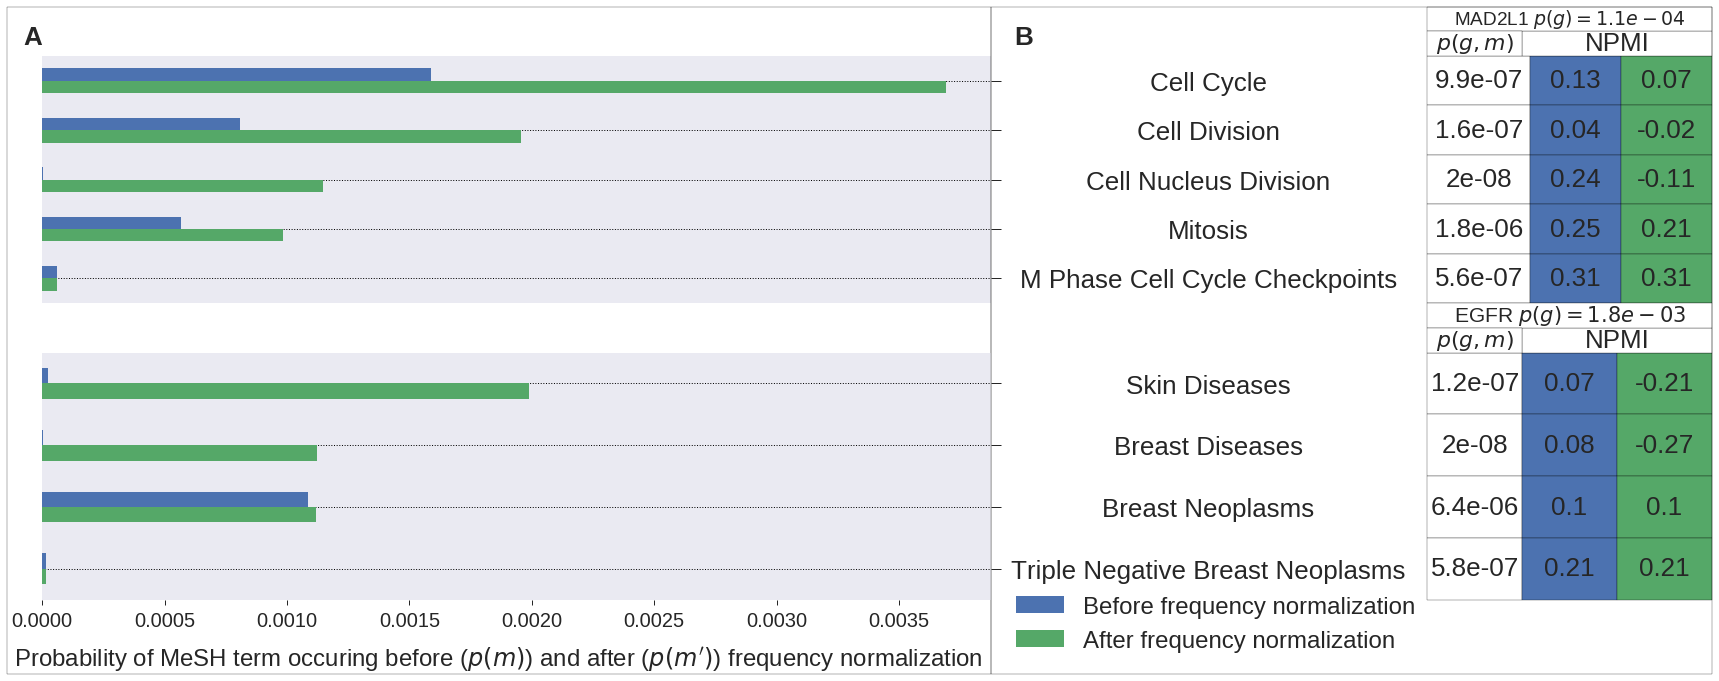

In [66]:
# sns.set_context("poster")

bd_ticks = [
        "Skin Diseases",
        "Breast Diseases",
        "Breast Neoplasms",
        "Triple Negative Breast Neoplasms"]
cc_ticks = [
        "Cell Cycle","Cell Division","Cell Nucleus Division","Mitosis","M Phase Cell Cycle Checkpoints"]

fig = plt.figure(figsize=(17.0,10.0))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212,sharex=ax1)

pd.DataFrame([
    gene_uid_original[gene_uid_original.uid.isin(cc_uids)].groupby(["name"]).d_freq.apply(lambda x: x.unique()[0]/n),
    gene_uid[gene_uid.uid.isin(cc_uids)].groupby("name").d_freq.apply(lambda x: x.unique()[0]/n)],
             index=["Before frequency normalization",
                 "After frequency normalization"]).T[["Before frequency normalization",
                                                         "After frequency normalization"]].loc[cc_ticks].plot(ax=ax1,
                                                                                            kind="barh",
#                                                                                             logx=True,
                                                                                            legend=False)
pd.DataFrame([
    gene_uid_original[gene_uid_original.uid.isin(bd_uids)].groupby(["name"]).d_freq.apply(lambda x: x.unique()[0]/n),
    gene_uid[gene_uid.uid.isin(bd_uids)].groupby("name").d_freq.apply(lambda x: x.unique()[0]/n)],
             index=["Before frequency normalization",
                 "After frequency normalization"]).T[["Before frequency normalization",
                                                         "After frequency normalization"]].loc[bd_ticks].plot(ax=ax2,
                                                                                            kind="barh",
#                                                                                             logx=True,
                                                                                            legend=False)

cc_table_data = cc_table_data.loc[cc_ticks].copy()

cc_table = ax1.table(cellText=cc_table_data.values,
                  cellLoc="center",
                  colWidths=[0.17,0.15,0.15],
                  loc="left",
                  bbox=(1.46,0,0.3,1),
#                   bbox=(1.4,0,0.3,1),   
                  transform = ax1.transAxes,
                  cellColours=[[(1.,1.,1.),sns.color_palette()[0],sns.color_palette()[1]]]*len(cc_ticks))
cc_header = ax1.table(cellText=[['NPMI']],
                   colWidths=[0.3],
                   cellLoc="center",
                   bbox=(1.56,1,0.2,.1),
                   loc='top left')
cc_header2 = ax1.table(cellText=[[r"MAD2L1 $p(g)=1.1e-04$"]],
                   colWidths=[0.3],
                   cellLoc="center",
                   bbox=(1.46,1.1,0.3,.1),
                   loc='top left')
cc_header3 = ax1.table(cellText=[[r"$p(g,m)$"]],
                   colWidths=[0.3],
                   cellLoc="center",
                   bbox=(1.46,1.,0.1,.1),
                   loc='top left')
cc_table.auto_set_font_size(False)
cc_table.scale(1,10)
cc_header.scale(1,5)
# ax1.set_yticklabels([])
ax1.set_ylabel("")
ax1.yaxis.tick_right()
ax1.tick_params(axis="y",length=10,right="on",left="off",pad=160)
# ax1.tick_params(axis="x",length=5)
# ax1.set_xlabel(r"proabability of MeSH term occuring ($p(m')$)")
ax1.invert_yaxis()
ax1.yaxis.grid(True,color="black",linestyle="dotted")
ax1.xaxis.grid(False)

bd_table_data = bd_table_data.loc[bd_ticks].copy()

bd_table = ax2.table(cellText=bd_table_data.values,
                  cellLoc="center",
                  colWidths=[0.15]*3,
                  loc="left",
                  bbox=(1.46,0,0.3,1),
                  transform = ax2.transAxes,
                  cellColours=[[(1.,1.,1.),sns.color_palette()[0],sns.color_palette()[1]]]*len(bd_ticks))
bd_header = ax2.table(cellText=[['NPMI']],
                   colWidths=[0.3],
                   cellLoc="center",
                   bbox=(1.56,1.,0.2,.1),
                   loc='top left')
bd_header2 = ax2.table(cellText=[[r"EGFR $p(g)=1.8e-03$"]],
                   colWidths=[0.3],
                   cellLoc="center",
                   bbox=(1.46,1.1,0.3,.1),
                   loc='top left')
bd_header3 = ax2.table(cellText=[[r"$p(g,m)$"]],
                   colWidths=[0.3],
                   cellLoc="center",
                   bbox=(1.46,1.,0.1,.1),
                   loc='top left')
bd_table.auto_set_font_size(False)
bd_table.scale(1,10)
bd_header.scale(1,5)
# ax2.set_yticklabels([])
ax2.set_ylabel("")
ax2.yaxis.tick_right()
ax2.tick_params(axis="y",length=10,right="on",left="off",pad=160)
ax2.tick_params(axis="x",length=5)
# ax2.set_xlabel(r"Probability of MeSH term occuring before ($p(m)$) and after ($p(m')$) frequency normalization")
ax2.invert_yaxis()
ax2.yaxis.grid(True,color="black",linestyle="dotted")
ax2.xaxis.grid(False)
# for r in ax1.patches:
#     ax1.annotate(np.round(r.get_width(),7),(r.get_width(),r.get_y()+0.25))
# for r in ax2.patches:
#     ax2.annotate(np.round(r.get_width(),7),(r.get_width(),r.get_y()+0.25))
    
handles, labels = ax1.get_legend_handles_labels()
# legend = ax2.legend(handles, labels,loc="lower right",bbox_to_anchor=(0.4175,0.95,0,1))
legend = ax2.legend(handles, labels,loc="lower right",bbox_to_anchor=(1.47,-0.3,0,1),fontsize=24)


legend.get_frame().set_facecolor("white")

for tick in ax1.yaxis.get_ticklabels():
    tick.set_horizontalalignment("center")
    tick.set_fontsize(26)
    tick.set_position((1.05,0))
for tick in ax2.yaxis.get_ticklabels():
    tick.set_horizontalalignment("center")
    tick.set_fontsize(26)
    tick.set_position((1.05,0))
for tick in ax2.xaxis.get_ticklabels():
    tick.set_fontsize(20)
# left, width = -0.037, 1.495
left, width = -0.037, 1.037
bottom, height = -1.5, 2.7
p = mpatches.Rectangle(
    (left, bottom), width, height,
    fill=False, transform=ax1.transAxes, clip_on=False, color="black"
    )

left2,width2 = 1,0.76

p2 = mpatches.Rectangle(
    (left2, bottom), width2, height,
    fill=False, transform=ax1.transAxes, clip_on=False, color="black"
    )

ax1.text(-0.02, 1.125, 'A',
         fontweight="bold",
        horizontalalignment='left',
        verticalalignment='top',
#          size=100,
        transform=ax1.transAxes)

ax1.text(1.025, 1.125, 'B',
         fontweight="bold",
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax1.transAxes)
ax1.text(-0.03, -1.5, r"Probability of MeSH term occuring before ($p(m)$) and after ($p(m')$) frequency normalization",
            size=24,
            horizontalalignment='left',
            verticalalignment='bottom',
            transform=ax1.transAxes)

ax1.add_patch(p)
ax2.add_patch(p2)
# ax1.invert_xaxis()
plt.savefig("ancestor_mapping.jpeg",dpi=500,transparent=False,bbox_inches="tight")

In [19]:
pd.DataFrame([
    gene_uid_original[gene_uid_original.uid.isin(cc_uids)].groupby(["name"]).d_freq.apply(lambda x: x.unique()[0]/n),
    gene_uid[gene_uid.uid.isin(cc_uids)].groupby("name").d_freq.apply(lambda x: x.unique()[0]/n)],
             index=["Before annotation bias correction",
                 "After annotation bias correction"]).T[["Before annotation bias correction",
                                                         "After annotation bias correction"]].loc[cc_ticks]

,Before annotation bias correction,After annotation bias correction
name,,
Cell Cycle,0.001587,0.003691
Cell Division,0.000806,0.001958
Cell Nucleus Division,0.000002,0.001147
Mitosis,0.000568,0.000982
M Phase Cell Cycle Checkpoints,0.000060,0.000060


In [20]:
pd.DataFrame([
    gene_uid_original[gene_uid_original.uid.isin(bd_uids)].groupby(["name"]).d_freq.apply(lambda x: x.unique()[0]/n),
    gene_uid[gene_uid.uid.isin(bd_uids)].groupby("name").d_freq.apply(lambda x: x.unique()[0]/n)],
             index=["Before annotation bias correction",
                 "After annotation bias correction"]).T[["Before annotation bias correction",
                                                         "After annotation bias correction"]].loc[bd_ticks]

,Before annotation bias correction,After annotation bias correction
name,,
Skin Diseases,0.000023,0.001987
Breast Diseases,0.000002,0.001121
Breast Neoplasms,0.001086,0.001117
Triple Negative Breast Neoplasms,0.000014,0.000014
